# Deep Convolutional GAN (DCGAN)

In this notebook, I use The **Street View House Numbers (SVHN) Dataset** [[1]](#ref1) to train DCGAN.  

If you are not familiar with GAN (Generative Adversarial Network), please see [gan_mnist.ipynb](gan_mnist.ipynb) that explains the concept in details using a simple network.  This notebook is a follow-up on that, and uses more convolutional networks for the generator and the discriminator.

The code is based on **Deep Convolutional GANs by Udacity** [[2]](#ref2).  Udacity uses TensorFlow but I use Keras on TensorFlow.

In [1]:
import numpy as np
from scipy.io import loadmat
import keras
import keras.backend as K
from keras.layers import Dense, Activation, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Loading SVHN Dataset

Download SVHN dataset from the Stanford website if not already done.

In [2]:
#
# Uncomment below to download SVHN datasets (it takes some time - a good time for a cup of coffee or two)
#
#!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
#!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

The data is in MATLAB format.  We use scipy's `loadmat` to load the data in numpy array.

In [3]:
train_data = loadmat('train_32x32.mat')
test_data  = loadmat('test_32x32.mat')

The `train_data` and `test_data` are `dict` object.  

They are the real images of house numbers but the shape is in (image_height, image_width, channels, records).

In [4]:
X_train, y_train = train_data['X'], train_data['y']
X_test,  y_test  = test_data['X'],  test_data['y']

X_train.shape

(32, 32, 3, 73257)

We roll the axis backward to make the shape to (records, image_height, image_width, channels).

In [5]:
# roll axis backward

X_train = np.rollaxis(X_train, 3)
X_test  = np.rollaxis(X_test, 3)

X_train.shape

(73257, 32, 32, 3)

Let's examine some sample images.

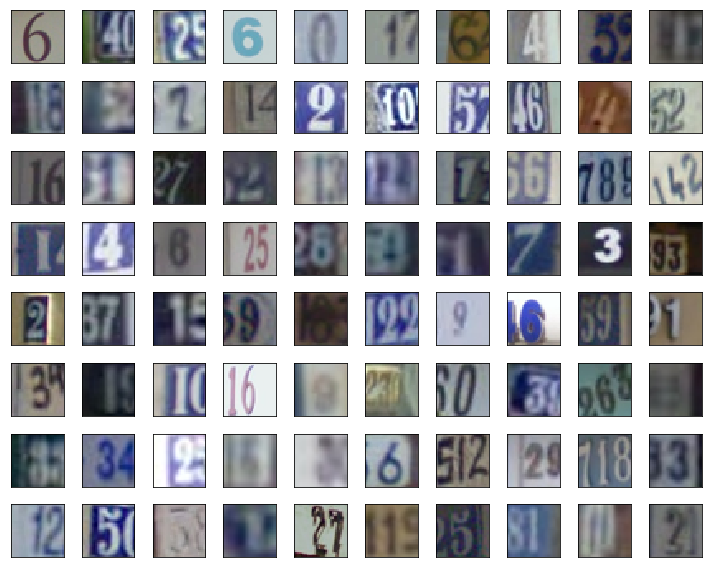

In [6]:
sample_images = X_train[np.random.choice(len(X_train), size=80, replace=False)]

plt.figure(figsize=(10, 8))
for i in range(80):
    plt.subplot(8, 10, i+1)
    plt.imshow(sample_images[i])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

## Preprocessing and Deprocessing

As usual, we need preprocessing and later deprocessing of the images.  

As we will see later on, the generator is using `tanh` activation, for which we need to preprocess the image data into the range between -1 and 1.

In [7]:
def preprocess(x):
    return (x/255)*2-1

def deprocess(x):
    return np.uint8((x+1)/2*255) # make sure to use uint8 type otherwise the image won't display properly

Apply the preprocessing on the train and test images (and they are the real images as oppose to the generated images).

In [8]:
X_train_real = preprocess(X_train)
X_test_real  = preprocess(X_test)

## Generator

The generator takes a latent sample (100 randomly generated numbers) and produces a 32x32 color image that should look like one from the SVHN dataset.

The original paper [[3]](#ref3) proposes the following generator network architecture.

<img src='../images/dcgan_svhn/generator.png' width='70%'>

In this notebook, I used smaller networks than this network, not only because the final image size is 32x32 and not 64x64, but also because my linux computer can not handle such a big network and I do not want to use AWS (Amazon Web Service) or other paid services.

The generator takes a latent sample which has 100 random numbers.  It uses the fully connected layer to expand the dimension to $4 \times 4 \times 256$ neurons so that it can be reshaped into 4x4 2D shape with 256 filters.

After that, each layer's height and width are doubled by the transpose convolution and the filters are halved.  The last layer produces a 32x32 2D image with 3 channels.

The activation of the output layer is `tanh` which the discriminator expects.



In [9]:
def make_generator(input_size, leaky_alpha):
    # generates images in (32,32,3)
    return Sequential([
        Dense(4*4*256, input_shape=(input_size,)),
        Reshape(target_shape=(4, 4, 256)),                              # 4,4,256
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'), # 8,8,128
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'), # 16,16,64
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        Conv2DTranspose(3, kernel_size=5, strides=2, padding='same'),   # 32,32,3
        Activation('tanh')
    ])

## Discriminator


The discriminator is a classifier to tell if the input image is real or fake.  

It is a convolutional neural network that takes a 32x32 image with 3 channels.  The values in the image is expected to be between -1 and 1.

The activation of the output layer is `sigmoid` and the discriminator outputs a probability of the image being real.

In [10]:
def make_discriminator(leaky_alpha):
    # classifies images in (32,32,3)
    return Sequential([        
        Conv2D(64, kernel_size=5, strides=2, padding='same',     # 16,16,64
               input_shape=(32,32,3)),
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        Conv2D(128, kernel_size=5, strides=2, padding='same'),   # 8,8,128
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        Conv2D(256, kernel_size=5, strides=2, padding='same'),   # 4,4,256
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        Flatten(),
        Dense(1),
        Activation('sigmoid')        
    ])

## DCGAN

We connect the generator and the discriminator to make a DCGAN.

The input to the DCGAN is a latent sample.  The generator inside DCGAN produces an image which is fed into the discriminator inside the DCGAN.  So, the output of DCGAN is the probability of the generated image being real.

In [11]:
# beta_1 is the exponential decay rate for the 1st moment estimates in Adam optimizer
def make_DCGAN(sample_size, 
               g_learning_rate, 
               g_beta_1,
               d_learning_rate,
               d_beta_1,
               leaky_alpha):
    # generator
    generator = make_generator(sample_size, leaky_alpha)

    # discriminator
    discriminator = make_discriminator(leaky_alpha)
    discriminator.compile(optimizer=Adam(lr=d_learning_rate, beta_1=d_beta_1), loss='binary_crossentropy')
    
    # GAN
    gan = Sequential([generator, discriminator])
    gan.compile(optimizer=Adam(lr=g_learning_rate, beta_1=g_beta_1), loss='binary_crossentropy')
    
    return gan, generator, discriminator

## Training DCGAN

The below is a function to generate latent samples.

In [12]:
def make_latent_samples(n_samples, sample_size):
    #return np.random.uniform(-1, 1, size=(n_samples, sample_size))
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

The below is a function to set the discriminator to trainable or non-trainable.

In [13]:
def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

The below is a function to create a batch of labels.

In [14]:
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

The training DCGAN is essentially the same as training a simple GAN in [gan_mnist.ipynb](gan_mnist.ipynb).

* set the discriminator trainable
* train the discriminator with real images with the label smoothing   (labels=1-smooth)
* train the discriminator with fake images generated by the generator (labels=0)
* set the discriminator non-trainable
* train the DCGAN with generated images (labels=1)

We repeat this process many times until the discriminator loss and the generator loss stabilizes.

In [15]:
sample_size     = 100     # latent sample size (i.e. 100 random numbers)
g_learning_rate = 0.0002  # learning rate for the generator
g_beta_1        = 0.9     # the exponential decay rate for the 1st moment estimates in Adam optimizer
d_learning_rate = 0.001   # learning rate for the discriminator
d_beta_1        = 0.9     # the exponential decay rate for the 1st moment estimates in Adam optimizer
leaky_alpha     = 0.01
epochs          = 100
batch_size      = 16      # train batch size
eval_size       = 16      # evaluate size
smooth          = 0.1

# labels for the batch size and the test size
y_train_real, y_train_fake = make_labels(batch_size)
y_eval_real,  y_eval_fake  = make_labels(eval_size)

# create a GAN, a generator and a discriminator
gan, generator, discriminator = make_DCGAN(
    sample_size, 
    g_learning_rate, 
    g_beta_1,
    d_learning_rate,
    d_beta_1,
    leaky_alpha)

losses = []
for e in range(epochs):
    for i in range(len(X_train_real)//batch_size):
        # real MNIST digit images
        X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]
        
        # latent samples and the generated digit images
        latent_samples = make_latent_samples(batch_size, sample_size)
        X_batch_fake = generator.predict_on_batch(latent_samples)
        
        # train the discriminator to detect real and fake images
        make_trainable(discriminator, True)
        discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
        discriminator.train_on_batch(X_batch_fake, y_train_fake)

        # train the generator via GAN
        make_trainable(discriminator, False)
        gan.train_on_batch(latent_samples, y_train_real)
    
    # evaluate
    X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]
    
    latent_samples = make_latent_samples(eval_size, sample_size)
    X_eval_fake = generator.predict_on_batch(latent_samples)

    d_loss = discriminator.test_on_batch(X_eval_real, y_eval_real)
    d_loss = discriminator.test_on_batch(X_eval_fake, y_eval_fake)
    g_loss = gan.test_on_batch(latent_samples, y_eval_real) # we want the fake to be realistic!
    
    losses.append((d_loss, g_loss))
    
    print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f}".format(
        e+1, epochs, d_loss, g_loss))    

Epoch:   1/100 Discriminator Loss: 0.2708 Generator Loss: 1.6390
Epoch:   2/100 Discriminator Loss: 0.2538 Generator Loss: 2.1673
Epoch:   3/100 Discriminator Loss: 0.3946 Generator Loss: 1.4510
Epoch:   4/100 Discriminator Loss: 0.2845 Generator Loss: 1.8508
Epoch:   5/100 Discriminator Loss: 0.6581 Generator Loss: 0.9925
Epoch:   6/100 Discriminator Loss: 0.8366 Generator Loss: 0.7456
Epoch:   7/100 Discriminator Loss: 0.3890 Generator Loss: 1.4067
Epoch:   8/100 Discriminator Loss: 0.4009 Generator Loss: 1.3724
Epoch:   9/100 Discriminator Loss: 0.3935 Generator Loss: 1.4524
Epoch:  10/100 Discriminator Loss: 0.2049 Generator Loss: 2.2440
Epoch:  11/100 Discriminator Loss: 0.3340 Generator Loss: 1.9087
Epoch:  12/100 Discriminator Loss: 0.3638 Generator Loss: 1.7425
Epoch:  13/100 Discriminator Loss: 0.3376 Generator Loss: 1.6799
Epoch:  14/100 Discriminator Loss: 0.1877 Generator Loss: 2.2406
Epoch:  15/100 Discriminator Loss: 0.2508 Generator Loss: 1.7526
Epoch:  16/100 Discrimina

## Results

The discriminator loss and the generator loss are shown below.  They both kind of stabilizes in the end.

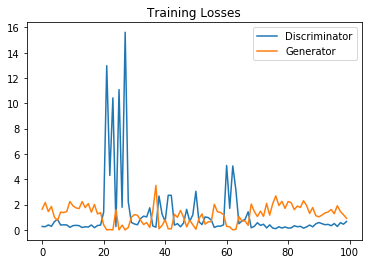

In [16]:
losses = np.array(losses)

fig, ax = plt.subplots()
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

We can generate new images using the generator.

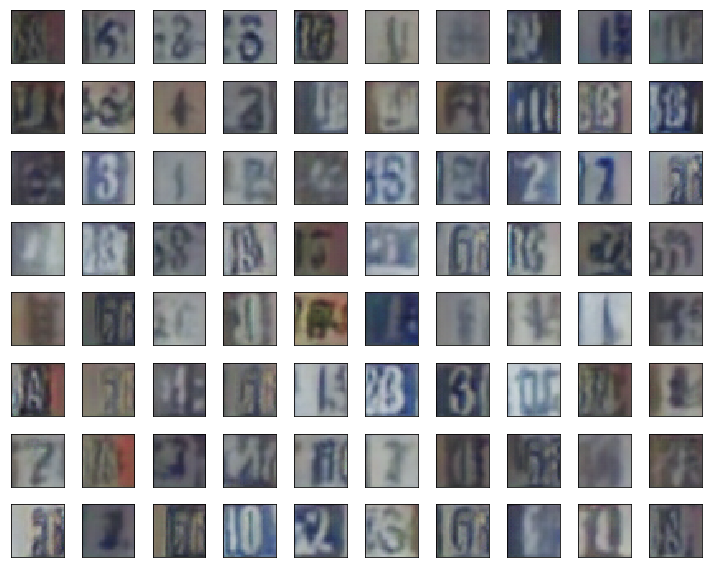

In [17]:
latent_samples = make_latent_samples(80, sample_size)
generated_digits = generator.predict(latent_samples)

plt.figure(figsize=(10, 8))
for i in range(80):
    img = deprocess(generated_digits[i])
    ax = plt.subplot(8, 10, i+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

### About Beta 1 Parameters

In the original DCGAN paper [[3]](#ref3), 0.5 is used for `beta_1` (the exponential decay rate for the 1st moment estimate that the Adam optimizer [[4]](#ref4) uses).  Adam uses an exponential average of weight gradients like the Momentum optimizer so that it keeps the momentum of weight updates and avoid random spikes and speed up/down as the momentum goes.

According to the original DCGAN paper [[3]](#ref3), it stabilizes the training better.

> we found leaving the momentum term β1 at the suggested value of 0.9 resulted in training oscillation and instability while reducing it to 0.5 helped stabilize training.

The generator in this project is not exactly the same as in the DCGAN paper [[3]](#ref3) but I also tried the following hyterparameters (attention to the g_beta_1 and d_beta_1).

```
sample_size     = 100     # latent sample size (i.e. 100 random numbers)
g_learning_rate = 0.0001  # learning rate for the generator
g_beta_1        = 0.5     # the exponential decay rate for the 1st moment estimates in Adam optimizer
d_learning_rate = 0.001   # learning rate for the discriminator
d_beta_1        = 0.5     # the exponential decay rate for the 1st moment estimates in Adam optimizer
leaky_alpha     = 0.01
epochs          = 100
batch_size      = 16      # train batch size
eval_size       = 16      # evaluate size
smooth          = 0.1
```

The generated images with beta_1 = 0.5 is not good with the networks I used.  I believe it depends on other hyperparameters and the network structure as well.

<table>
    <tr>
        <td width='40%'><img src='../images/dcgan_svhn/losses.png'  align='left'/></td>
        <td><img src='../images/dcgan_svhn/generated.png' align='left'/></td>
    </tr>
</table>

## References

<a id="ref1"></a>
### [1] The Street View House Numbers (SVHN) Dataset

Stanford

http://ufldl.stanford.edu/housenumbers/

<a id="ref2"></a>
### [2] Deep Convolutional GANs

Udacity

https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb

<a id="ref3"></a>
### [3] Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks

Alec Radford & Luke Metz (indico Research), Soumith Chintala (Facebook AI Research)

https://arxiv.org/pdf/1511.06434.pdf

<a id="ref4"></a>
### [4] ADAM: A Method for Stocastic Optimization

Diederik P. Kingma (University of Amsterdam, OpenAI), Jimmy Lei Ba (University of Toronto)

https://arxiv.org/pdf/1412.6980.pdf